# <center>Redes generativas adversarias</center>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

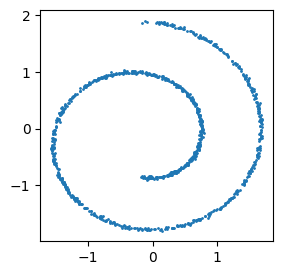

In [2]:
def get_batch(batch_size=1000, noise=0.1):
    x, _ = make_swiss_roll(batch_size, noise=noise)
    x = x[:, [0, 2]]
    x = (x - x.mean()) / x.std()
    return torch.tensor(x).float()

# Ejemplo:
samples = get_batch()
plt.figure(figsize=(3, 3))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

In [3]:
generator = lambda data_dim, latent_dim: nn.Sequential(
    nn.Linear(latent_dim, 32), nn.ReLU(),
    nn.Linear(32, 64), nn.ReLU(),
    nn.Linear(64, 128), nn.ReLU(),
    nn.Linear(128, data_dim)
)

discriminator = lambda data_dim: nn.Sequential(
    nn.Linear(data_dim, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 32), nn.ReLU(),
    nn.Linear(32, 1), nn.Sigmoid()
)

In [4]:
class GAN:

    def __init__(self, data_dim=2, latent_dim=16):

        self.latent_dim = latent_dim

        self.generator = generator(data_dim, latent_dim)
        self.discriminator = discriminator(data_dim)
        self.generator_optimizer = optim.Adam(self.generator.parameters(), lr=0.002, betas=(0.5, 0.999))
        self.discriminator_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

    def train(self, iters, batch_fn=get_batch):

        for iter in range(iters):
            
            # Datos de entrenamiento:
            x_true = batch_fn()
            x_fake = self.generator(torch.randn([len(x_true), self.latent_dim]))

            # Entrenamiento discriminador:
            loss_y1 = torch.log(self.discriminator(x_true)).mean(dim=0)
            loss_y0 = torch.log(1-self.discriminator(x_fake.detach())).mean(dim=0)
            loss_discriminator = - 1 / 2 * (loss_y1 + loss_y0)
            self.discriminator_optimizer.zero_grad()
            loss_discriminator.backward()
            self.discriminator_optimizer.step()

            # Entrenamiento generador:
            loss_generator = 1 / 2 * torch.log(1-self.discriminator(x_fake)).mean(dim=0)
            self.generator_optimizer.zero_grad()
            loss_generator.backward()
            self.generator_optimizer.step()
            
    def generate_samples(self, n_samples):
        z = torch.randn([n_samples, self.latent_dim])
        samples = self.generator(z)
        return samples

In [5]:
gan = GAN()
gan.train(iters=5000)

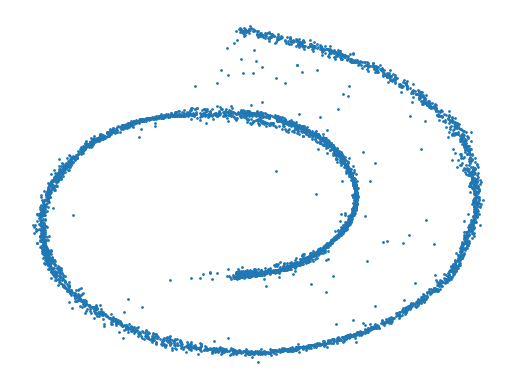

In [ ]:
# Generación.
samples = gan.generate_samples(5000).detach()
plt.figure(figsize=(3, 3))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()